# Using with `pyspark` for data preprocessing

We want to use pyspark to preprocess a potentially huge dataset used for
web-marketing.

## Data description

The data is a `parquet` file which contains a dataframe with 8 columns:

-   `xid`: unique user id
-   `action`: type of action. ‘C’ is a click, ‘O’ or ‘VSL’ is a
    web-display
-   `date`: date of the action
-   `website_id`: unique id of the website
-   `url`: url of the webpage
-   `category_id`: id of the display
-   `zipcode`: postal zipcode of the user
-   `device`: type of device used by the user

## Q1. Some statistics / computations

Using `pyspark.sql` we want to do the following things:

1.  Compute the total number of unique users
2.  Construct a column containing the total number of actions per user
3.  Construct a column containing the number of days since the last
    action of the user
4.  Construct a column containing the number of actions of each user for
    each modality of device

## Q2. Binary classification

Then, we want to construct a classifier to predict the click on the
category 1204. Here is an agenda for this:

1.  Construction of a features matrix for which each line corresponds to
    the information concerning a user.
2.  In this matrix, we need to keep only the users that have been
    exposed to the display in category 1204
3.  Using this training dataset, train a binary classifier, and evaluate
    your classifier using a precision / recall curve computed on test
    data.

# Download/read the data and a first look at the data

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
from pyspark.sql import SparkSession

> **Spark in standalone mode**
>
> So far, we used the `local` mode.
>
> To launch spark in standalone mode, assuming the current working
> directory is `$SPARK_HOME`
>
> ``` bash
> $ ./sbin/sWe may tart-master.sh --ip localhost
> >>> starting org.apache.spark.deploy.master.Master, logging to ...
> $ ./sbin/start-worker.sh spark://localhost:7077
> ```
>
> We may now launch the instance of `SparkSession`, setting explicitly
> the `master` node and the port to communicate with the master.
>
> SparkUI should be reachable at `localhost:4040`.
>
> The master can be monitored at `localhost:8080`

In [3]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.functions import col

spark = (SparkSession
    .builder
    .appName("Taming Webdata")
    .getOrCreate()
)

sc = spark._sc

25/05/12 10:28:21 WARN Utils: Your hostname, boucheron-Precision-5480 resolves to a loopback address: 127.0.1.1; using 172.23.32.10 instead (on interface eth0)
25/05/12 10:28:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 10:28:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable

In [4]:
spark = SparkSession.builder \
            .appName("Spark webdata") \
            .master("spark://localhost:7077") \
            .config("spark.driver.memory", "16G") \
            .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
            .config("spark.kryoserializer.buffer.max", "2000M") \
            .config("spark.driver.maxResultSize", "0") \
            .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.2.3") \
            .getOrCreate()

In [5]:
#spark = (SparkSession
#    .builder
#    .appName("Web data")         
#    .getOrCreate()
#)

In [6]:
import requests, zipfile, io
from pathlib import Path

path = Path('data/webdata.parquet')
if not path.exists():
    url = "https://s-v-b.github.io/IFEBY310/data/webdata.parquet.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path='data/')

In [7]:
input_path = Path('./data')
input_file =  'webdata.parquet'
file_path = str(input_path / input_file)

df = spark.read.parquet(file_path)

We can give a try to Pandas on Spark

> **Note**
>
> We can also give a try to `pyarrow.parquet` module to load the Parquet
> file in an Arrow table.

In [8]:
import pyarrow as pa
import comet as co
import pyarrow.parquet as pq

dfa = pq.read_table(file_path)

In [9]:
dfa.num_columns

8

> **Warning**
>
> Let us go back to the spark data frame

In [10]:
df.head(6)

[Row(xid='001ff9b6-5383-4221-812d-58c2c3f234cc', action='O', date=datetime.datetime(2017, 1, 25, 7, 2, 18), website_id='3', url='http://www.8chances.com/grille', category_id=1002.0, zipcode='11370', device='SMP'),
 Row(xid='0056ab7a-3cba-4ed5-a495-3d4abf79ab66', action='O', date=datetime.datetime(2016, 12, 28, 9, 47, 8), website_id='54', url='http://www.salaire-brut-en-net.fr/differences-brut-net/', category_id=1002.0, zipcode='86000', device='DSK'),
 Row(xid='005ae4ab-363a-41a0-b8f9-faee47d622a4', action='O', date=datetime.datetime(2017, 1, 27, 22, 21, 6), website_id='74', url='http://www.realite-virtuelle.com/top-applications-horreur-vr-halloween', category_id=1002.0, zipcode='49700', device='DSK'),
 Row(xid='006f867c-70cb-41f0-82af-f3688fa719c5', action='O', date=datetime.datetime(2016, 12, 20, 12, 45, 14), website_id='43', url='http://www.frenchblues.fr/', category_id=1002.0, zipcode='42660', device='DSK'),
 Row(xid='006f867c-70cb-41f0-82af-f3688fa719c5', action='O', date=datetime.

In [11]:
df.show(5)

+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
|                 xid|action|               date|website_id|                 url|category_id|zipcode|device|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
|001ff9b6-5383-422...|     O|2017-01-25 07:02:18|         3|http://www.8chanc...|     1002.0|  11370|   SMP|
|0056ab7a-3cba-4ed...|     O|2016-12-28 09:47:08|        54|http://www.salair...|     1002.0|  86000|   DSK|
|005ae4ab-363a-41a...|     O|2017-01-27 22:21:06|        74|http://www.realit...|     1002.0|  49700|   DSK|
|006f867c-70cb-41f...|     O|2016-12-20 12:45:14|        43|http://www.french...|     1002.0|  42660|   DSK|
|006f867c-70cb-41f...|     O|2016-12-20 12:56:50|        43|http://www.french...|     1002.0|  42660|   DSK|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
only showing top 5 

In [12]:
df.describe()

DataFrame[summary: string, xid: string, action: string, website_id: string, url: string, category_id: string, zipcode: string, device: string]

In [13]:
df.printSchema()

root
 |-- xid: string (nullable = true)
 |-- action: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- website_id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- category_id: float (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- device: string (nullable = true)


In [14]:
df.rdd.getNumPartitions()

12

> **Question**
>
> Explain the partition size.

# Basic statistics

First we need to import some things:

-   `Window` class
-   SQL functions module
-   Some very useful functions
-   Spark types

In [15]:
from pyspark.sql import Window
import pyspark.sql.functions as func
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit

## Compute the total number of unique users

In [16]:
( 
    df.select('xid')
      .distinct()
      .count()
)

473761

In [17]:
def foo(x):
   c = len(set(x))
   print(c)
   return c

In [18]:
foo([1, 1, 2])

2

2

In [19]:
df.rdd.map(lambda x : x.xid).foreachPartition(foo)

0
0
0
0
0
0
[Stage 9:========================>                                 (5 + 7) / 12][Stage 9:=============================>                            (6 + 6) / 12]78120
[Stage 9:=================================>                        (7 + 5) / 12]78636
79090
78865
79296
[Stage 9:====================================================>    (11 + 1) / 12]79754
                                                                                

In [20]:
78120 + 78636 + 79090 + 78865 + 79296 + 79754

473761

This might pump up some computational resources

In [21]:
( 
    df.select('xid')
      .distinct() 
      .explain()
)

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[xid#0], functions=[])
   +- Exchange hashpartitioning(xid#0, 200), ENSURE_REQUIREMENTS, [plan_id=136]
      +- HashAggregate(keys=[xid#0], functions=[])
         +- FileScan parquet [xid#0] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/home/boucheron/Documents/IFEBY310/core/ipynb/data/webdata.parquet], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<xid:string>



> **Note**
>
> The distinct values of `xid` seem to be evenly spread among the six
> files making the `parquet` directory

## Construct a column containing the total number of actions per user

In [22]:
xid_partition = Window.partitionBy('xid')

n_events = func.count(col('action')).over(xid_partition)

df = df.withColumn('n_events', n_events)

df.show(n=2)

+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+--------+
|                 xid|action|               date|website_id|                 url|category_id|zipcode|device|n_events|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+--------+
|0006cea7-1679-426...|     O|2016-12-26 13:41:08|        51|https://www.footl...|     1002.0|  34290|   TAB|       1|
|000893c8-a14b-4f3...|     O|2016-12-23 16:18:37|        56|http://blague.dum...|     1002.0|   NULL|   DSK|       1|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+--------+
only showing top 2 rows


In [23]:
( 
  df
    .groupBy('xid')
    .agg(func.count('action'))
    .show(n=5)
)

+--------------------+-------------+
|                 xid|count(action)|
+--------------------+-------------+
|001c4a21-52c6-489...|            1|
|0024344b-7ee2-4fc...|            4|
|004564e3-87c1-4e1...|            1|
|006d807f-91c3-415...|            1|
|006e0463-b24c-499...|            1|
+--------------------+-------------+
only showing top 5 rows


Visualize the distribution of the number of users per number of actions.

> **Question**
>
> Construct a column containing the number of days since the last action
> of the user

In [24]:
# xid_partition = Window.partitionBy('xid')

max_date = (
  func
    .max(col('date'))
    .over(xid_partition)
)

n_days_since_last_event = func.datediff(func.current_date(), max_date)

df = df.withColumn('n_days_since_last_event',
                   n_days_since_last_event)

df.show(n=2)

+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+--------+-----------------------+
|                 xid|action|               date|website_id|                 url|category_id|zipcode|device|n_events|n_days_since_last_event|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+--------+-----------------------+
|0006cea7-1679-426...|     O|2016-12-26 13:41:08|        51|https://www.footl...|     1002.0|  34290|   TAB|       1|                   3059|
|000893c8-a14b-4f3...|     O|2016-12-23 16:18:37|        56|http://blague.dum...|     1002.0|   NULL|   DSK|       1|                   3062|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+--------+-----------------------+
only showing top 2 rows


In [25]:
df.printSchema()

root
 |-- xid: string (nullable = true)
 |-- action: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- website_id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- category_id: float (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- device: string (nullable = true)
 |-- n_events: long (nullable = false)
 |-- n_days_since_last_event: integer (nullable = true)


## Construct a column containing the number of actions of each user for each modality of device

In [26]:
xid_device_partition = xid_partition.partitionBy('device')

n_events_per_device = func.count(col('action')).over(xid_device_partition)

df = df.withColumn('n_events_per_device', n_events_per_device)

df.head(n=2)

[Stage 21:==>                                                     (1 + 20) / 22]                                                                                

[Row(xid='000893c8-a14b-4f33-858f-210440f37def', action='O', date=datetime.datetime(2016, 12, 23, 16, 18, 37), website_id='56', url='http://blague.dumatin.fr/', category_id=1002.0, zipcode=None, device='DSK', n_events=1, n_days_since_last_event=3062, n_events_per_device=1021837),
 Row(xid='0008c5d2-c263-4b55-ae7d-82c4bf566cc4', action='O', date=datetime.datetime(2017, 1, 16, 4, 26, 21), website_id='74', url='http://www.realite-virtuelle.com/meilleure-videos-360-vr', category_id=1002.0, zipcode=None, device='DSK', n_events=1, n_days_since_last_event=3038, n_events_per_device=1021837)]

## Number of devices per user

In [27]:
xid_partition = Window.partitionBy('xid')

rank_device = (
  func
    .dense_rank()
    .over(xid_partition.orderBy('device'))
)

n_unique_device = (
    func
      .last(rank_device)
      .over(xid_partition)
)

df = df.withColumn('n_device', n_unique_device)

df.head(n=2)

[Stage 30:======================================>                   (2 + 1) / 3]                                                                                

[Row(xid='0006cea7-1679-4264-bdef-0cd089749ede', action='O', date=datetime.datetime(2016, 12, 26, 13, 41, 8), website_id='51', url='https://www.footlegende.fr/mercato-psg-coutinho-10166', category_id=1002.0, zipcode='34290', device='TAB', n_events=1, n_days_since_last_event=3059, n_events_per_device=132013, n_device=1),
 Row(xid='000893c8-a14b-4f33-858f-210440f37def', action='O', date=datetime.datetime(2016, 12, 23, 16, 18, 37), website_id='56', url='http://blague.dumatin.fr/', category_id=1002.0, zipcode=None, device='DSK', n_events=1, n_days_since_last_event=3062, n_events_per_device=1021837, n_device=1)]

In [28]:
df\
    .where(col('n_device') > 1)\
    .select('xid', 'device', 'n_events',  'n_device', 'n_events_per_device')\
    .head(n=8)

[Stage 40:=============================>                            (1 + 1) / 2]                                                                                

[Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837),
 Row(xid='4c1dc79d-a140-4da9-ae28-540b4503c3b8', device='MOB', n_events=6, n_device=2, n_events_per_device=1564),
 Row(xid='78156cdf-7229-46eb-bb6b-92d384f9a6fa', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837),
 Row(xid='78156cdf-7229-46eb-bb6b-92d384f9a6fa', device='DSK', n_events=6, n_device=2, n_events_per_device=1021837)]

In [29]:
df\
    .where(col('n_device') > 1)\
    .select('xid', 'device', 'n_events',  'n_device', 'n_events_per_device')\
    .count()

3153

# Let’s select the correct users and build a training dataset

We construct a ETL (Extract Transform Load) process on this data using
the `pyspark.sql` API.

## Extraction

Here extraction is just about reading the data

In [30]:
df = spark.read.parquet(file_path)
df.show(n=3)

+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
|                 xid|action|               date|website_id|                 url|category_id|zipcode|device|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
|001ff9b6-5383-422...|     O|2017-01-25 07:02:18|         3|http://www.8chanc...|     1002.0|  11370|   SMP|
|0056ab7a-3cba-4ed...|     O|2016-12-28 09:47:08|        54|http://www.salair...|     1002.0|  86000|   DSK|
|005ae4ab-363a-41a...|     O|2017-01-27 22:21:06|        74|http://www.realit...|     1002.0|  49700|   DSK|
+--------------------+------+-------------------+----------+--------------------+-----------+-------+------+
only showing top 3 rows


## Transformation of the data

At this step we compute a lot of extra things from the data. The aim is
to build *features* that describe users.

In [31]:
def n_events_transformer(df):
    xid_partition = Window.partitionBy('xid')
    n_events = func.count(col('action')).over(xid_partition)
    
    df = df.withColumn('n_events', n_events)

    return df

In [32]:
def n_events_per_action_transformer(df):
    xid_action_partition = Window.partitionBy('xid', 'action')
    n_events_per_action = func.count(col('action')).over(xid_action_partition)

    df = df.withColumn('n_events_per_action', n_events_per_action)
    
    return df

In [33]:
def hour_transformer(df):
    hour = func.hour(col('date'))
    df = df.withColumn('hour', hour)
    return df

def weekday_transformer(df):
    weekday = func.date_format(col('date'), 'EEEE')
    df = df.withColumn('weekday', weekday)
    return df

def n_events_per_hour_transformer(df):
    xid_hour_partition = Window.partitionBy('xid', 'hour')
    n_events_per_hour = func.count(col('action')).over(xid_hour_partition)
    df = df.withColumn('n_events_per_hour', n_events_per_hour)
    return df

def n_events_per_weekday_transformer(df):
    xid_weekday_partition = Window.partitionBy('xid', 'weekday')
    n_events_per_weekday = func.count(col('action')).over(xid_weekday_partition)
    df = df.withColumn('n_events_per_weekday', n_events_per_weekday)
    return df

def n_days_since_last_event_transformer(df):
    xid_partition = Window.partitionBy('xid')
    max_date = func.max(col('date')).over(xid_partition)
    n_days_since_last_event = func.datediff(func.current_date(), max_date)
    df = df.withColumn('n_days_since_last_event',
                       n_days_since_last_event + lit(0.1))
    return df

def n_days_since_last_action_transformer(df):
    xid_partition_action = Window.partitionBy('xid', 'action')
    max_date = func.max(col('date')).over(xid_partition_action)
    n_days_since_last_action = func.datediff(func.current_date(),
                                                        max_date)
    df = df.withColumn('n_days_since_last_action',
                       n_days_since_last_action + lit(0.1))
    return df

def n_unique_day_transformer(df):
    xid_partition = Window.partitionBy('xid')
    dayofyear = func.dayofyear(col('date'))
    rank_day = func.dense_rank().over(xid_partition.orderBy(dayofyear))
    n_unique_day = func.last(rank_day).over(xid_partition)
    df = df.withColumn('n_unique_day', n_unique_day)
    return df

def n_unique_hour_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_hour = func.dense_rank().over(xid_partition.orderBy('hour'))
    n_unique_hour = func.last(rank_hour).over(xid_partition)
    df = df.withColumn('n_unique_hour', n_unique_hour)
    return df

def n_events_per_device_transformer(df):
    xid_device_partition = Window.partitionBy('xid', 'device')
    n_events_per_device = func.count(func.col('device')) \
        .over(xid_device_partition)
    df = df.withColumn('n_events_per_device', n_events_per_device)
    return df

def n_unique_device_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_device = func.dense_rank().over(xid_partition.orderBy('device'))
    n_unique_device = func.last(rank_device).over(xid_partition)
    df = df.withColumn('n_device', n_unique_device)
    return df

def n_actions_per_category_id_transformer(df):
    xid_category_id_partition = Window.partitionBy('xid', 'category_id',
                                                   'action')
    n_actions_per_category_id = func.count(func.col('action')) \
        .over(xid_category_id_partition)
    df = df.withColumn('n_actions_per_category_id', n_actions_per_category_id)
    return df

def n_unique_category_id_transformer(df):
    xid_partition = Window.partitionBy('xid')
    rank_category_id = func.dense_rank().over(xid_partition\
                                              .orderBy('category_id'))
    n_unique_category_id = func.last(rank_category_id).over(xid_partition)
    df = df.withColumn('n_unique_category_id', n_unique_category_id)
    return df

def n_events_per_category_id_transformer(df):
    xid_category_id_partition = Window.partitionBy('xid', 'category_id')
    n_events_per_category_id = func.count(func.col('action')) \
        .over(xid_category_id_partition)
    df = df.withColumn('n_events_per_category_id', n_events_per_category_id)
    return df

def n_events_per_website_id_transformer(df):
    xid_website_id_partition = Window.partitionBy('xid', 'website_id')
    n_events_per_website_id = func.count(col('action'))\
        .over(xid_website_id_partition)
    df = df.withColumn('n_events_per_website_id', n_events_per_website_id)
    return df

In [34]:
transformers = [
    hour_transformer,
    weekday_transformer,
    n_events_per_hour_transformer,
    n_events_per_weekday_transformer,
    n_days_since_last_event_transformer,
    n_days_since_last_action_transformer,
    n_unique_day_transformer,
    n_unique_hour_transformer,
    n_events_per_device_transformer,
    n_unique_device_transformer,
    n_actions_per_category_id_transformer,
    n_events_per_category_id_transformer,
    n_events_per_website_id_transformer,
]

In [35]:
N = 10000

In [36]:
sample_df = df.sample(withReplacement=False, fraction=.05)

In [37]:
sample_df.count()

59140

In [38]:
for transformer in transformers:
    df = transformer(df)

df.head(n=1)

[Stage 58:>                                                         (0 + 1) / 1]                                                                                

[Row(xid='0006cea7-1679-4264-bdef-0cd089749ede', action='O', date=datetime.datetime(2016, 12, 26, 13, 41, 8), website_id='51', url='https://www.footlegende.fr/mercato-psg-coutinho-10166', category_id=1002.0, zipcode='34290', device='TAB', hour=13, weekday='Monday', n_events_per_hour=1, n_events_per_weekday=1, n_days_since_last_event=3059.1, n_days_since_last_action=3059.1, n_unique_day=1, n_unique_hour=1, n_events_per_device=1, n_device=1, n_actions_per_category_id=1, n_events_per_category_id=1, n_events_per_website_id=1)]

In [39]:
for transformer in transformers:
    sample_df = transformer(sample_df)

sample_df.head(n=1)

[Row(xid='0004d0b7-a7fd-44ca-accc-422b62de4436', action='O', date=datetime.datetime(2017, 1, 19, 8, 22, 14), website_id='3', url='http://www.8chances.com/grille', category_id=1204.0, zipcode='78480', device='DSK', hour=8, weekday='Thursday', n_events_per_hour=1, n_events_per_weekday=1, n_days_since_last_event=3035.1, n_days_since_last_action=3035.1, n_unique_day=1, n_unique_hour=1, n_events_per_device=1, n_device=1, n_actions_per_category_id=1, n_events_per_category_id=1, n_events_per_website_id=1)]

In [40]:
df = sample_df

In [41]:
sorted(df.columns)

['action',
 'category_id',
 'date',
 'device',
 'hour',
 'n_actions_per_category_id',
 'n_days_since_last_action',
 'n_days_since_last_event',
 'n_device',
 'n_events_per_category_id',
 'n_events_per_device',
 'n_events_per_hour',
 'n_events_per_website_id',
 'n_events_per_weekday',
 'n_unique_day',
 'n_unique_hour',
 'url',
 'website_id',
 'weekday',
 'xid',
 'zipcode']

## Load step

Here, we use all the previous computations (saved in the columns of the
dataframe) to compute aggregated informations about each user.

In [42]:
def n_events_per_hour_loader(df):
    csr = df\
        .select('xid', 'hour', 'n_events_per_hour')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()     # action
    feature_name = func.concat(lit('n_events_per_hour#'), col('hour'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('hour')
    return csr

def n_events_per_website_id_loader(df):
    csr = df.select('xid', 'website_id', 'n_events_per_website_id')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_website_id#'),
                               col('website_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('website_id')
    return csr

def n_events_per_hour_loader(df):
    csr = df\
        .select('xid', 'hour', 'n_events_per_hour')\
        .withColumnRenamed('n_events_per_hour', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_hour#'), col('hour'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('hour')
    return csr

def n_events_per_weekday_loader(df):
    csr = df\
        .select('xid', 'weekday', 'n_events_per_weekday')\
        .withColumnRenamed('n_events_per_weekday', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_weekday#'), col('weekday'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('weekday')
    return csr

def n_days_since_last_event_loader(df):
    csr = df.select('xid',  'n_days_since_last_event')\
        .withColumnRenamed('n_days_since_last_event#', 'value')\
        .distinct()
    feature_name = lit('n_days_since_last_event')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_days_since_last_action_loader(df):
    csr = df.select('xid', 'action', 'n_days_since_last_action')\
        .withColumnRenamed('n_days_since_last_action', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_days_since_last_action#'), col('action'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('action')
    return csr

def n_unique_day_loader(df):
    csr = df.select('xid', 'n_unique_day')\
        .withColumnRenamed('n_unique_day', 'value')\
        .distinct()
    feature_name = lit('n_unique_day')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_unique_hour_loader(df):
    csr = df.select('xid', 'n_unique_hour')\
        .withColumnRenamed('n_unique_hour', 'value')\
        .distinct()
    feature_name = lit('n_unique_hour')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_events_per_device_loader(df):
    csr = df\
        .select('xid', 'device', 'n_events_per_device')\
        .withColumnRenamed('n_events_per_device', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_device#'), col('device'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('device')
    return csr

def n_unique_device_loader(df):
    csr = df.select('xid', 'n_device')\
        .withColumnRenamed('n_device', 'value')\
        .distinct()
    feature_name = lit('n_device')
    csr = csr\
        .withColumn('feature_name', feature_name)
    return csr

def n_events_per_category_id_loader(df):
    csr = df.select('xid', 'category_id', 'n_events_per_category_id')\
        .withColumnRenamed('n_events_per_category_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_category_id#'),
                               col('category_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('category_id')
    return csr

def n_actions_per_category_id_loader(df):
    csr = df.select('xid', 'category_id', 'action', 'n_actions_per_category_id')\
        .withColumnRenamed('n_actions_per_category_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_actions_per_category_id#'),
                               col('action'), lit('#'), 
                               col('category_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('category_id')\
        .drop('action')
    return csr

def n_events_per_website_id_loader(df):
    csr = df.select('xid', 'website_id', 'n_events_per_website_id')\
        .withColumnRenamed('n_events_per_website_id', 'value')\
        .distinct()
    feature_name = func.concat(lit('n_events_per_website_id#'),
                               col('website_id'))
    csr = csr\
        .withColumn('feature_name', feature_name)\
        .drop('website_id')
    return csr

In [43]:
from functools import reduce

In [44]:
loaders = [
    n_events_per_hour_loader,
    n_events_per_website_id_loader,
    n_events_per_hour_loader,
    n_events_per_weekday_loader,
    n_days_since_last_event_loader,
    n_days_since_last_action_loader,
    n_unique_day_loader,
    n_unique_hour_loader,
    n_events_per_device_loader,
    n_unique_device_loader,
    n_events_per_category_id_loader,
    n_actions_per_category_id_loader,
    n_events_per_website_id_loader,
]

In [45]:
def union(df, other):
    return df.union(other)

> **About DataFrame.union()**
>
> This method performs a SQL-style set union of the rows from both
> DataFrame objects, with no automatic deduplication of elements.
>
> Use the distinct() method to perform deduplication of rows.
>
> The method resolves columns by position (not by name), following the
> standard behavior in SQL.

In [46]:
spam = [loader(df) for loader in loaders]

In [47]:
spam[0].printSchema()

root
 |-- xid: string (nullable = true)
 |-- value: long (nullable = false)
 |-- feature_name: string (nullable = true)


In [48]:
len(spam)

13

In [49]:
csr = reduce(
    lambda df1, df2: df1.union(df2),
    spam
)

csr.head(n=3)

[Row(xid='0004d0b7-a7fd-44ca-accc-422b62de4436', value=1.0, feature_name='n_events_per_hour#8'),
 Row(xid='000fcd14-ce41-461d-a2aa-cb407630a03a', value=5.0, feature_name='n_events_per_hour#16'),
 Row(xid='0013cccf-fd6b-4794-8951-ab362875b6d2', value=1.0, feature_name='n_events_per_hour#1')]

In [50]:
csr.columns

['xid', 'value', 'feature_name']

In [51]:
csr.show(5)

+--------------------+-----+--------------------+
|                 xid|value|        feature_name|
+--------------------+-----+--------------------+
|0004d0b7-a7fd-44c...|  1.0| n_events_per_hour#8|
|000fcd14-ce41-461...|  5.0|n_events_per_hour#16|
|0013cccf-fd6b-479...|  1.0| n_events_per_hour#1|
|0015f89f-cc8d-4fb...|  1.0| n_events_per_hour#9|
|0015f89f-cc8d-4fb...|  1.0|n_events_per_hour#17|
+--------------------+-----+--------------------+
only showing top 5 rows


In [52]:
csr.rdd.getNumPartitions()

17

In [53]:
# Replace features names and xid by a unique number
feature_name_partition = Window().orderBy('feature_name')
xid_partition = Window().orderBy('xid')

col_idx = func.dense_rank().over(feature_name_partition)
row_idx = func.dense_rank().over(xid_partition)

In [54]:
csr = csr.withColumn('col', col_idx)\
    .withColumn('row', row_idx)

csr = csr.na.drop('any')

csr.head(n=5)

25/05/12 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 1

[Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=1.0, feature_name='n_actions_per_category_id#O#1204.0', col=4, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=3019.1, feature_name='n_days_since_last_action#O', col=6, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=3019.1, feature_name='n_days_since_last_event', col=7, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=1.0, feature_name='n_device', col=8, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=1.0, feature_name='n_events_per_category_id#1204.0', col=10, row=1)]

In [55]:
# Let's save the result of our hard work into a new parquet file
output_path = Path('./data')
output_file = str(output_path / 'csr.parquet')
csr.write.parquet(output_file, mode='overwrite')

25/05/12 10:28:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 1

# Preparation of the training dataset

In [56]:
csr_path = './data'
csr_file = os.path.join(csr_path, 'csr.parquet')

df = spark.read.parquet(csr_file)
df.head(n=5)

[Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=1.0, feature_name='n_actions_per_category_id#O#1204.0', col=4, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=3019.1, feature_name='n_days_since_last_action#O', col=6, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=3019.1, feature_name='n_days_since_last_event', col=7, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=1.0, feature_name='n_device', col=8, row=1),
 Row(xid='0003214f-7e9d-4aa1-8ba3-dcdf71ad2a40', value=1.0, feature_name='n_events_per_category_id#1204.0', col=10, row=1)]

In [57]:
df.count()

520140

In [58]:
# What are the features related to campaign_id 1204 ?
features_names = \
    df.select('feature_name')\
    .distinct()\
    .toPandas()['feature_name']

In [59]:
features_names

0      n_events_per_website_id#25
1     n_events_per_weekday#Sunday
2      n_events_per_website_id#42
3             n_events_per_hour#0
4            n_events_per_hour#10
                 ...             
93           n_events_per_hour#19
94     n_events_per_website_id#29
95     n_events_per_website_id#60
96    n_events_per_weekday#Monday
97     n_events_per_website_id#32
Name: feature_name, Length: 98, dtype: object

In [60]:
[feature_name for feature_name in features_names if '1204' in feature_name]

['n_events_per_category_id#1204.0',
 'n_actions_per_category_id#C#1204.0',
 'n_actions_per_category_id#O#1204.0']

In [61]:
# Look for the xid that have at least one exposure to campaign 1204
keep = func.when(
    (col('feature_name') == 'n_actions_per_category_id#C#1204.0') |
    (col('feature_name') == 'n_actions_per_category_id#O#1204.0'),
    1).otherwise(0)
df = df.withColumn('keep', keep)

df.where(col('keep') > 0).count()

10892

In [62]:
# Sum of the keeps :)
xid_partition = Window.partitionBy('xid')
sum_keep = func.sum(col('keep')).over(xid_partition)
df = df.withColumn('sum_keep', sum_keep)

In [63]:
# Let's keep the xid exposed to 1204
df = df.where(col('sum_keep') > 0)

In [64]:
df.count()

155787

In [65]:
df.select('xid').distinct().count()

10886

In [66]:
row_partition = Window().orderBy('row')
col_partition = Window().orderBy('col')
row_new = func.dense_rank().over(row_partition)
col_new = func.dense_rank().over(col_partition)
df = df.withColumn('row_new', row_new)
df = df.withColumn('col_new', col_new)
csr_data = df.select('row_new', 'col_new', 'value').toPandas()

25/05/12 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 1

In [67]:
csr_data.head()

In [68]:
features_names = df.select('feature_name', 'col_new').distinct()
features_names.where(col('feature_name') == 'n_actions_per_category_id#C#1204.0').head()

25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 1

Row(feature_name='n_actions_per_category_id#C#1204.0', col_new=2)

In [69]:
features_names.where(col('feature_name') == 'n_actions_per_category_id#O#1204.0').head()

25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 1

Row(feature_name='n_actions_per_category_id#O#1204.0', col_new=4)

In [70]:
from scipy.sparse import csr_matrix
import numpy as np

rows = csr_data['row_new'].values - 1
cols = csr_data['col_new'].values - 1
vals = csr_data['value'].values

X_csr = csr_matrix((vals, (rows, cols)))

In [71]:
X_csr.shape

(10886, 80)

In [72]:
X_csr.shape, X_csr.nnz

((10886, 80), 130320)

In [73]:
X_csr.nnz / (X_csr.shape[0]* X_csr.shape[1])   # 0152347 * 92)

0.1496417416865699

In [74]:
# The label vector. Let's make it dense, flat and binary
y = np.array(X_csr[:, 1].todense()).ravel()
y = np.array(y > 0, dtype=np.int64)

In [75]:
X_csr.shape

(10886, 80)

In [76]:
# We remove the second and fourth column. 
# It actually contain the label we'll want to predict.
kept_cols = list(range(X_csr.shape[1]))
kept_cols.pop(1)
kept_cols.pop(2)
X = X_csr[:, kept_cols]

In [77]:
len(kept_cols)

78

In [78]:
X_csr.shape, X.shape

((10886, 80), (10886, 78))

## Finally !!

Wow ! That was a lot of work. Now we have a features matrix $X$ and a
vector of labels $y$.

In [79]:
X.indices

array([ 3,  4,  5, ..., 75, 76, 77], shape=(119428,), dtype=int32)

In [80]:
X.indptr

array([     0,     10,     20, ..., 119408, 119418, 119428],
      shape=(10887,), dtype=int32)

In [81]:
X.shape, X.nnz

((10886, 78), 119428)

In [82]:
y.shape, y.sum()

((10886,), np.int64(80))

# Some learning for/from this data

In [83]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Normalize the features
X = MaxAbsScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

clf = LogisticRegression(
    penalty='l2',
    C=1e3,
    solver='lbfgs',
    class_weight='balanced'
)

clf.fit(X_train, y_train)

LogisticRegression(C=1000.0, class_weight='balanced') In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. LogisticRegression ? Documentation for LogisticRegression i Fitted LogisticRegression(C=1000.0, class_weight='balanced')

In [84]:
features_names = features_names.toPandas()['feature_name']

25/05/12 10:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.

In [85]:
features_names[range(6)]

0    n_actions_per_category_id#C#1002.0
1    n_actions_per_category_id#C#1204.0
2    n_actions_per_category_id#O#1002.0
3    n_actions_per_category_id#O#1204.0
4            n_days_since_last_action#C
5            n_days_since_last_action#O
Name: feature_name, dtype: object

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Logistic regression coefficients')

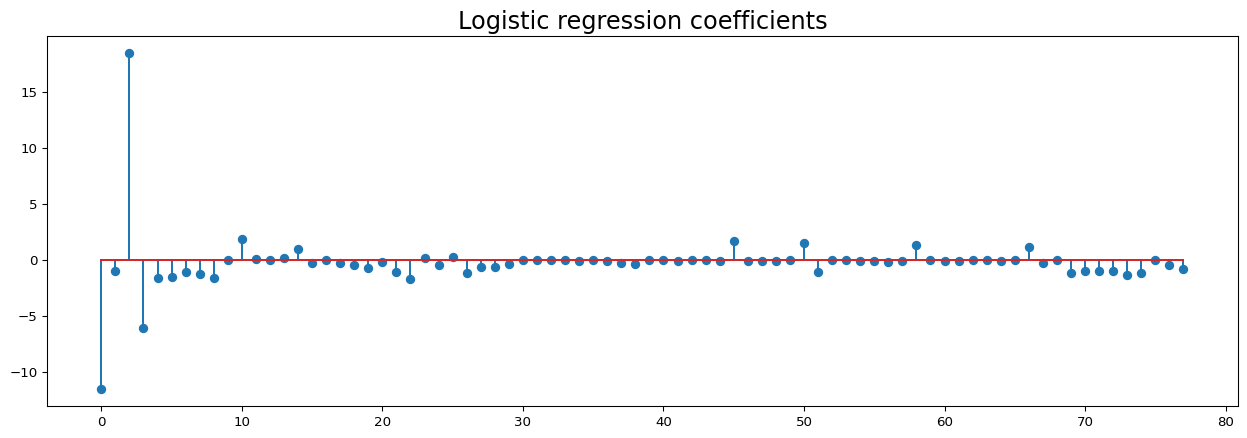

In [87]:
plt.figure(figsize=(16, 5))
plt.stem(clf.coef_[0]) # , use_line_collection=True)
plt.title('Logistic regression coefficients', fontsize=18)

In [88]:
clf.coef_[0].shape[0]

78

In [89]:
len(features_names)

80

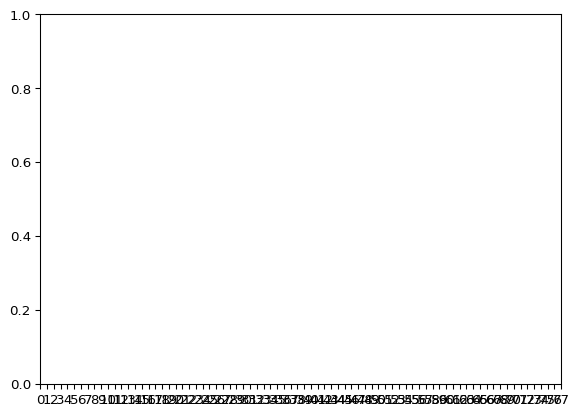

In [90]:
# We change the fontsize of minor ticks label
_ = plt.xticks(np.arange(clf.coef_[0].shape[0]), features_names, 
           rotation='vertical', fontsize=8)

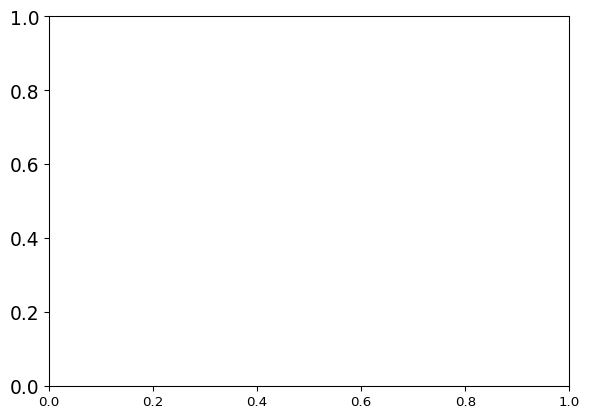

In [91]:
_ = plt.yticks(fontsize=14)

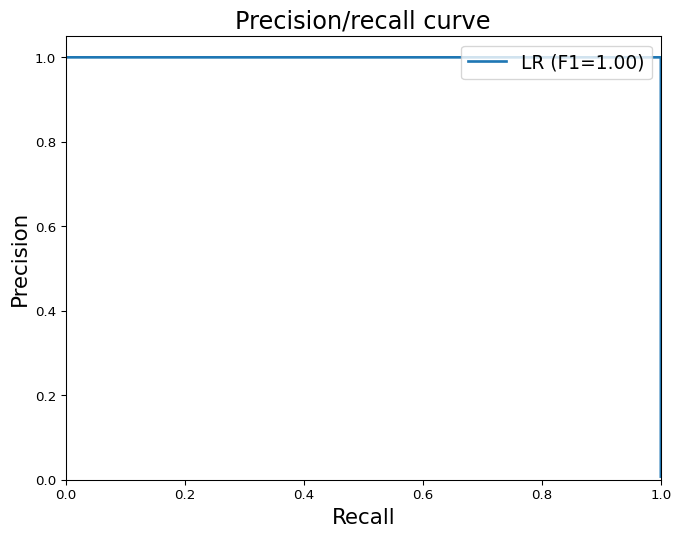

In [92]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='LR (F1=%.2f)' % f1_score(y_test, clf.predict(X_test)), lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision/recall curve', fontsize=18)
plt.legend(loc="upper right", fontsize=14)

# Analyse the tables

In [93]:
query = """ANALYZE TABLE db_table COMPUTE STATISTICS
            FOR COLUMNS xid"""

In [94]:
df.createOrReplaceTempView("db_table")

In [95]:
df.columns

['xid',
 'value',
 'feature_name',
 'col',
 'row',
 'keep',
 'sum_keep',
 'row_new',
 'col_new']

In [96]:
spark.sql("cache table db_table")

25/05/12 10:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 10:28:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/05/12 1

DataFrame[]

In [97]:
spark.sql(query)

DataFrame[]

In [98]:
spark.sql("show tables")

DataFrame[namespace: string, tableName: string, isTemporary: boolean]